In [1]:
import numpy as np
import pandas as pd
import datetime
from datetime import datetime, timedelta
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

pd.set_option('display.max_columns', 50)
df = pd.read_csv('winter_Anapa.csv')
df.head()

,flight_id,aircraft_code,status,arrival_airport,scheduled_departure,scheduled_arrival,actual_departure,actual_arrival,amount_total,actual_duration,amount_per_min
0,136316,733,Arrived,SVO,2017-01-12T10:05:00Z,2017-01-12T11:45:00Z,2017-01-12T10:07:00Z,2017-01-12T11:47:00Z,1886000.0,100.0,18860.00000
1,136226,733,Arrived,SVO,2017-01-30T10:05:00Z,2017-01-30T11:45:00Z,2017-01-30T10:08:00Z,2017-01-30T11:48:00Z,1886000.0,100.0,18860.00000
2,136389,733,Arrived,SVO,2017-01-18T10:05:00Z,2017-01-18T11:45:00Z,2017-01-18T10:10:00Z,2017-01-18T11:50:00Z,1873800.0,100.0,18738.00000
3,136403,733,Arrived,SVO,2017-02-20T10:05:00Z,2017-02-20T11:45:00Z,2017-02-20T10:06:00Z,2017-02-20T11:46:00Z,1873800.0,100.0,18738.00000
4,136275,733,Arrived,SVO,2017-01-13T10:05:00Z,2017-01-13T11:45:00Z,2017-01-13T10:08:00Z,2017-01-13T11:46:00Z,1825000.0,98.0,18622.44898


Загрузим дополнительные данные, полученные из таблиц исходной базы данных путем предварительной обработки

In [2]:
# Данные по количеству мест в самолетах
plane = pd.read_csv('planes.csv', index_col='aircraft_code')
plane.head()

,seats
aircraft_code,
319,116
320,140
321,170
733,130
763,222


In [3]:
# Данные по количеству занятых мест в самолете
occupied = pd.read_csv('occupied_seats.csv', index_col='flight_id')
occupied.head()

,occupied_seats
flight_id,
2,94
3,97
7,101
8,94
9,116


In [4]:
# Данные аэропортов
airports = pd.read_csv('airport_coordinates.csv', index_col='airport_code')
airports.head()

,longitude,latitude
airport_code,,
AAQ,37.347301,45.002102
ABA,91.385002,53.740002
AER,39.956600,43.449902
ARH,40.716702,64.600304
ASF,48.006302,46.283298


Cоздадим словарь расстояний от Анапы (AAQ) до всех аэропортов в анализируемом периоде
distance {Аэропорт: расстояние в километрах}
Для этого используем новую библиотеку geopy
!pip install geopy

In [5]:
from geopy.distance import geodesic
distance = {}
arrival_airports = list(df.arrival_airport.unique())

In [6]:
for airport in arrival_airports:
    distance[airport] = round(geodesic((airports.loc['AAQ'].longitude, airports.loc['AAQ'].latitude), (airports.loc[airport].longitude, airports.loc[airport].latitude)).km)                    

In [7]:
# добавим в исходный датафрейм признак distance и заполним его по данным словаря
df.loc[:, 'distance'] = df.arrival_airport.apply(lambda x: distance[x])
df.head()

,flight_id,aircraft_code,status,arrival_airport,scheduled_departure,scheduled_arrival,actual_departure,actual_arrival,amount_total,actual_duration,amount_per_min,distance
0,136316,733,Arrived,SVO,2017-01-12T10:05:00Z,2017-01-12T11:45:00Z,2017-01-12T10:07:00Z,2017-01-12T11:47:00Z,1886000.0,100.0,18860.00000,971
1,136226,733,Arrived,SVO,2017-01-30T10:05:00Z,2017-01-30T11:45:00Z,2017-01-30T10:08:00Z,2017-01-30T11:48:00Z,1886000.0,100.0,18860.00000,971
2,136389,733,Arrived,SVO,2017-01-18T10:05:00Z,2017-01-18T11:45:00Z,2017-01-18T10:10:00Z,2017-01-18T11:50:00Z,1873800.0,100.0,18738.00000,971
3,136403,733,Arrived,SVO,2017-02-20T10:05:00Z,2017-02-20T11:45:00Z,2017-02-20T10:06:00Z,2017-02-20T11:46:00Z,1873800.0,100.0,18738.00000,971
4,136275,733,Arrived,SVO,2017-01-13T10:05:00Z,2017-01-13T11:45:00Z,2017-01-13T10:08:00Z,2017-01-13T11:46:00Z,1825000.0,98.0,18622.44898,971


Из открытых источников информации взята информация о расходе топлива: 
http://newsruss.ru/doc/index.php/Расход_топлива_самолета
код Марка самолета       Расход топлива   
SU9 Sukhoi Superjet-100  1.7 т/час      
733 Boeing 737-300       2.4 т/час

А также определена стоимость аваитоплива по месяцам из Анапы: 
https://favt.gov.ru/dejatelnost-ajeroporty-i-ajerodromy-ceny-na-aviagsm/?id=7329
Месяц         Цена за 1т топлива (без НДС) руб.
Январь 2017   41435
Февраль 2017  39553

In [8]:
# рассчитаем затраты на топливо по каждому рейсу и запишем их в новый признак fuel_costs
fuel = {'SU9': 1.7, '733': 2.4}
cost = {1:41435, 2:39553}
df.actual_departure = pd.to_datetime(df.actual_departure)
for row in range(df.shape[0]):
    df.loc[row, 'fuel_costs'] = round(df.loc[row, 'actual_duration']/60*fuel[df.loc[row, 'aircraft_code']]*cost[df.loc[row, 'actual_departure'].month])

In [10]:
# рассчитаем теперь валовую прибыль по каждому рейсу - признак profit
df.loc[:, 'profit'] = df.amount_total - df.fuel_costs

In [11]:
df.sample(10)

,flight_id,aircraft_code,status,arrival_airport,scheduled_departure,scheduled_arrival,actual_departure,actual_arrival,amount_total,actual_duration,amount_per_min,distance,fuel_costs,profit
117,136807,SU9,Arrived,EGO,2017-02-23T09:25:00Z,2017-02-23T10:15:00Z,2017-02-23 09:28:00+00:00,2017-02-23T10:18:00Z,531000.0,50.0,10620.000000,509,56033.0,474967.0
29,136119,733,Arrived,SVO,2017-01-03T10:05:00Z,2017-01-03T11:45:00Z,2017-01-03 10:08:00+00:00,2017-01-03T11:49:00Z,1653000.0,101.0,16366.336634,971,167397.0,1485603.0
80,136706,SU9,Arrived,EGO,2017-01-06T09:25:00Z,2017-01-06T10:15:00Z,2017-01-06 09:30:00+00:00,2017-01-06T10:20:00Z,740100.0,50.0,14802.000000,509,58700.0,681400.0
74,136956,SU9,Arrived,EGO,2017-02-04T09:25:00Z,2017-02-04T10:15:00Z,2017-02-04 09:33:00+00:00,2017-02-04T10:23:00Z,746400.0,50.0,14928.000000,509,56033.0,690367.0
72,136605,SU9,Arrived,EGO,2017-02-15T09:25:00Z,2017-02-15T10:15:00Z,2017-02-15 09:28:00+00:00,2017-02-15T10:19:00Z,765300.0,51.0,15005.882353,509,57154.0,708146.0
36,136411,733,Arrived,SVO,2017-02-04T10:05:00Z,2017-02-04T11:45:00Z,2017-02-04 10:06:00+00:00,2017-02-04T11:46:00Z,1590800.0,100.0,15908.000000,971,158212.0,1432588.0
49,136857,SU9,Arrived,EGO,2017-02-13T09:25:00Z,2017-02-13T10:15:00Z,2017-02-13 09:31:00+00:00,2017-02-13T10:21:00Z,765300.0,50.0,15306.000000,509,56033.0,709267.0
6,136249,733,Arrived,SVO,2017-02-14T10:05:00Z,2017-02-14T11:45:00Z,2017-02-14 10:08:00+00:00,2017-02-14T11:46:00Z,1800600.0,98.0,18373.469388,971,155048.0,1645552.0
42,136758,SU9,Arrived,EGO,2017-01-12T09:25:00Z,2017-01-12T10:15:00Z,2017-01-12 09:26:00+00:00,2017-01-12T10:15:00Z,765300.0,49.0,15618.367347,509,57526.0,707774.0
82,136185,733,Arrived,SVO,2017-01-14T10:05:00Z,2017-01-14T11:45:00Z,2017-01-14 10:06:00+00:00,2017-01-14T11:49:00Z,1520000.0,103.0,14757.281553,971,170712.0,1349288.0


In [16]:
# добавим в исходный датафрейм также данные о количестве мест в самолете и о количестве занятых мест
df.loc[:, 'seats'] = df.aircraft_code.apply(lambda x: plane.loc[x, 'seats'])
df.loc[:, 'occupied_seats'] = df.flight_id.apply(lambda x: occupied.loc[x, 'occupied_seats'])

In [17]:
# создадим новый признак: perc_occupied - доля занятых мест
df.loc[:, 'perc_occupied'] = df.occupied_seats/df.seats

In [18]:
# Создадим призак дня недели даты отправления по расписанию weekday: 1-понедельник, 2-вторник, ..., 7- воскресенье
df.scheduled_departure = pd.to_datetime(df.scheduled_departure)
df.loc[:, 'weekday'] = df.scheduled_departure.apply(lambda x: x.weekday() + 1)

In [19]:
df.sample(10)

,flight_id,aircraft_code,status,arrival_airport,scheduled_departure,scheduled_arrival,actual_departure,actual_arrival,amount_total,actual_duration,amount_per_min,distance,fuel_costs,profit,seats,occupied_seats,perc_occupied,weekday
113,136922,SU9,Arrived,EGO,2017-02-11 09:25:00+00:00,2017-02-11T10:15:00Z,2017-02-11 09:27:00+00:00,2017-02-11T10:17:00Z,607800.0,50.0,12156.000000,509,56033.0,551767.0,97,76,0.783505,6
81,136669,SU9,Arrived,EGO,2017-01-17 09:25:00+00:00,2017-01-17T10:15:00Z,2017-01-17 09:26:00+00:00,2017-01-17T10:17:00Z,752700.0,51.0,14758.823529,509,59874.0,692826.0,97,95,0.979381,2
33,136269,733,Arrived,SVO,2017-02-11 10:05:00+00:00,2017-02-11T11:45:00Z,2017-02-11 10:13:00+00:00,2017-02-11T11:53:00Z,1605400.0,100.0,16054.000000,971,158212.0,1447188.0,130,109,0.838462,6
34,136146,733,Arrived,SVO,2017-02-09 10:05:00+00:00,2017-02-09T11:45:00Z,2017-02-09 10:08:00+00:00,2017-02-09T11:48:00Z,1604200.0,100.0,16042.000000,971,158212.0,1445988.0,130,109,0.838462,4
63,136819,SU9,Arrived,EGO,2017-01-04 09:25:00+00:00,2017-01-04T10:15:00Z,2017-01-04 09:29:00+00:00,2017-01-04T10:19:00Z,759000.0,50.0,15180.000000,509,58700.0,700300.0,97,96,0.989691,3
106,136936,SU9,Arrived,EGO,2017-01-02 09:25:00+00:00,2017-01-02T10:15:00Z,2017-01-02 09:28:00+00:00,2017-01-02T10:18:00Z,632400.0,50.0,12648.000000,509,58700.0,573700.0,97,82,0.845361,1
48,136366,733,Arrived,SVO,2017-01-11 10:05:00+00:00,2017-01-11T11:45:00Z,2017-01-11 10:08:00+00:00,2017-01-11T11:47:00Z,1527400.0,99.0,15428.282828,971,164083.0,1363317.0,130,103,0.792308,3
15,136164,733,Arrived,SVO,2017-01-07 10:05:00+00:00,2017-01-07T11:45:00Z,2017-01-07 10:07:00+00:00,2017-01-07T11:46:00Z,1738400.0,99.0,17559.595960,971,164083.0,1574317.0,130,120,0.923077,6
94,136855,SU9,Arrived,EGO,2017-01-11 09:25:00+00:00,2017-01-11T10:15:00Z,2017-01-11 12:07:00+00:00,2017-01-11T12:57:00Z,702300.0,50.0,14046.000000,509,58700.0,643600.0,97,87,0.896907,3
26,136268,733,Arrived,SVO,2017-02-16 10:05:00+00:00,2017-02-16T11:45:00Z,2017-02-16 10:08:00+00:00,2017-02-16T11:49:00Z,1676200.0,101.0,16596.039604,971,159794.0,1516406.0,130,115,0.884615,4


In [20]:
# проверим возможные статусы полета
df.status.value_counts()
# везде статус Arrived - признак неинформативен

Arrived    118
Name: status, dtype: int64

In [21]:
# удалим все признаки с датами отправления-прибытия (кроме scheduled_departure) и обозначенный выше как излишний
df.drop(columns=['status', 'scheduled_arrival', 'actual_departure', 'actual_arrival'], inplace=True)

In [22]:
df.sample(10)

,flight_id,aircraft_code,arrival_airport,scheduled_departure,amount_total,actual_duration,amount_per_min,distance,fuel_costs,profit,seats,occupied_seats,perc_occupied,weekday
76,136630,SU9,EGO,2017-02-25 09:25:00+00:00,746400.0,50.0,14928.000000,509,56033.0,690367.0,97,94,0.969072,6
10,136463,733,SVO,2017-01-20 10:05:00+00:00,1788400.0,99.0,18064.646465,971,164083.0,1624317.0,130,122,0.938462,5
40,136266,733,SVO,2017-02-27 10:05:00+00:00,1566400.0,100.0,15664.000000,971,158212.0,1408188.0,130,108,0.830769,1
22,136264,733,SVO,2017-02-18 10:05:00+00:00,1690800.0,100.0,16908.000000,971,158212.0,1532588.0,130,116,0.892308,6
61,136672,SU9,EGO,2017-02-03 09:25:00+00:00,759000.0,50.0,15180.000000,509,56033.0,702967.0,97,96,0.989691,5
53,136875,SU9,EGO,2017-02-16 09:25:00+00:00,765300.0,50.0,15306.000000,509,56033.0,709267.0,97,97,1.000000,4
38,136420,733,SVO,2017-01-01 10:05:00+00:00,1542000.0,98.0,15734.693878,971,162425.0,1379575.0,130,104,0.800000,7
80,136706,SU9,EGO,2017-01-06 09:25:00+00:00,740100.0,50.0,14802.000000,509,58700.0,681400.0,97,95,0.979381,5
85,136202,733,SVO,2017-01-05 10:05:00+00:00,1495600.0,102.0,14662.745098,971,169055.0,1326545.0,130,100,0.769231,4
81,136669,SU9,EGO,2017-01-17 09:25:00+00:00,752700.0,51.0,14758.823529,509,59874.0,692826.0,97,95,0.979381,2


In [23]:
# рассмотрим наименее прибыльные маршруты, с учетом того, что маршрутов всего 2 и летают они в одно и то же время каждый
# посмотрим 10% наименее прибыльных маршрутов из расчета показателя amount_per_min
df[df.amount_per_min<df.amount_per_min.quantile(0.10)]

,flight_id,aircraft_code,arrival_airport,scheduled_departure,amount_total,actual_duration,amount_per_min,distance,fuel_costs,profit,seats,occupied_seats,perc_occupied,weekday
106,136936,SU9,EGO,2017-01-02 09:25:00+00:00,632400.0,50.0,12648.000000,509,58700.0,573700.0,97,82,0.845361,1
107,136678,SU9,EGO,2017-01-28 09:25:00+00:00,631200.0,50.0,12624.000000,509,58700.0,572500.0,97,80,0.824742,6
108,136937,SU9,EGO,2017-01-03 09:25:00+00:00,626100.0,50.0,12522.000000,509,58700.0,567400.0,97,81,0.835052,2
109,136888,SU9,EGO,2017-02-14 09:25:00+00:00,626100.0,50.0,12522.000000,509,56033.0,570067.0,97,79,0.814433,2
110,136620,SU9,EGO,2017-02-17 09:25:00+00:00,613500.0,49.0,12520.408163,509,54913.0,558587.0,97,79,0.814433,5
111,136645,SU9,EGO,2017-01-05 09:25:00+00:00,633000.0,51.0,12411.764706,509,59874.0,573126.0,97,82,0.845361,4
112,136823,SU9,EGO,2017-02-05 09:25:00+00:00,620400.0,51.0,12164.705882,509,57154.0,563246.0,97,78,0.804124,7
113,136922,SU9,EGO,2017-02-11 09:25:00+00:00,607800.0,50.0,12156.000000,509,56033.0,551767.0,97,76,0.783505,6
114,136887,SU9,EGO,2017-01-20 09:25:00+00:00,595200.0,49.0,12146.938776,509,57526.0,537674.0,97,78,0.804124,5
115,136844,SU9,EGO,2017-02-28 09:25:00+00:00,575100.0,50.0,11502.000000,509,56033.0,519067.0,97,79,0.814433,2


отметим что в эту группу попали только рейсы в аэропорт EGO

In [32]:
# посмотрим 10% наименее прибыльных маршрутов из расчета показателя profit
df[df.profit<df.profit.quantile(0.10)]

,flight_id,aircraft_code,arrival_airport,scheduled_departure,amount_total,actual_duration,amount_per_min,distance,fuel_costs,profit,seats,occupied_seats,perc_occupied,weekday
106,136936,SU9,EGO,2017-01-02 09:25:00+00:00,632400.0,50.0,12648.000000,509,58700.0,573700.0,97,82,0.845361,1
107,136678,SU9,EGO,2017-01-28 09:25:00+00:00,631200.0,50.0,12624.000000,509,58700.0,572500.0,97,80,0.824742,6
108,136937,SU9,EGO,2017-01-03 09:25:00+00:00,626100.0,50.0,12522.000000,509,58700.0,567400.0,97,81,0.835052,2
109,136888,SU9,EGO,2017-02-14 09:25:00+00:00,626100.0,50.0,12522.000000,509,56033.0,570067.0,97,79,0.814433,2
110,136620,SU9,EGO,2017-02-17 09:25:00+00:00,613500.0,49.0,12520.408163,509,54913.0,558587.0,97,79,0.814433,5
111,136645,SU9,EGO,2017-01-05 09:25:00+00:00,633000.0,51.0,12411.764706,509,59874.0,573126.0,97,82,0.845361,4
112,136823,SU9,EGO,2017-02-05 09:25:00+00:00,620400.0,51.0,12164.705882,509,57154.0,563246.0,97,78,0.804124,7
113,136922,SU9,EGO,2017-02-11 09:25:00+00:00,607800.0,50.0,12156.000000,509,56033.0,551767.0,97,76,0.783505,6
114,136887,SU9,EGO,2017-01-20 09:25:00+00:00,595200.0,49.0,12146.938776,509,57526.0,537674.0,97,78,0.804124,5
115,136844,SU9,EGO,2017-02-28 09:25:00+00:00,575100.0,50.0,11502.000000,509,56033.0,519067.0,97,79,0.814433,2


полученные датасеты полностью идеинтичны, что говорит об отсутствии разницы в оценке прибыльности по признаку amount_per_min или признаку profit

In [26]:
# проанализируем теперь 10% наименее загруженных рейсов
df[df.perc_occupied<df.perc_occupied.quantile(0.10)]

,flight_id,aircraft_code,arrival_airport,scheduled_departure,amount_total,actual_duration,amount_per_min,distance,fuel_costs,profit,seats,occupied_seats,perc_occupied,weekday
38,136420,733,SVO,2017-01-01 10:05:00+00:00,1542000.0,98.0,15734.693878,971,162425.0,1379575.0,130,104,0.800000,7
48,136366,733,SVO,2017-01-11 10:05:00+00:00,1527400.0,99.0,15428.282828,971,164083.0,1363317.0,130,103,0.792308,3
82,136185,733,SVO,2017-01-14 10:05:00+00:00,1520000.0,103.0,14757.281553,971,170712.0,1349288.0,130,104,0.800000,6
85,136202,733,SVO,2017-01-05 10:05:00+00:00,1495600.0,102.0,14662.745098,971,169055.0,1326545.0,130,100,0.769231,4
89,136360,733,SVO,2017-02-05 10:05:00+00:00,1455400.0,100.0,14554.000000,971,158212.0,1297188.0,130,97,0.746154,7
90,136178,733,SVO,2017-01-29 10:05:00+00:00,1434600.0,99.0,14490.909091,971,164083.0,1270517.0,130,99,0.761538,7
91,136122,733,SVO,2017-01-08 10:05:00+00:00,1431000.0,100.0,14310.000000,971,165740.0,1265260.0,130,97,0.746154,7
96,136464,733,SVO,2017-01-09 10:05:00+00:00,1398000.0,100.0,13980.000000,971,165740.0,1232260.0,130,100,0.769231,1
97,136250,733,SVO,2017-02-08 10:05:00+00:00,1407800.0,101.0,13938.613861,971,159794.0,1248006.0,130,99,0.761538,3
113,136922,SU9,EGO,2017-02-11 09:25:00+00:00,607800.0,50.0,12156.000000,509,56033.0,551767.0,97,76,0.783505,6


In [27]:
# рассмотрим 10% рейсов с наименьшей выручкой
df[df.amount_total<df.amount_total.quantile(0.10)]

,flight_id,aircraft_code,arrival_airport,scheduled_departure,amount_total,actual_duration,amount_per_min,distance,fuel_costs,profit,seats,occupied_seats,perc_occupied,weekday
106,136936,SU9,EGO,2017-01-02 09:25:00+00:00,632400.0,50.0,12648.000000,509,58700.0,573700.0,97,82,0.845361,1
107,136678,SU9,EGO,2017-01-28 09:25:00+00:00,631200.0,50.0,12624.000000,509,58700.0,572500.0,97,80,0.824742,6
108,136937,SU9,EGO,2017-01-03 09:25:00+00:00,626100.0,50.0,12522.000000,509,58700.0,567400.0,97,81,0.835052,2
109,136888,SU9,EGO,2017-02-14 09:25:00+00:00,626100.0,50.0,12522.000000,509,56033.0,570067.0,97,79,0.814433,2
110,136620,SU9,EGO,2017-02-17 09:25:00+00:00,613500.0,49.0,12520.408163,509,54913.0,558587.0,97,79,0.814433,5
111,136645,SU9,EGO,2017-01-05 09:25:00+00:00,633000.0,51.0,12411.764706,509,59874.0,573126.0,97,82,0.845361,4
112,136823,SU9,EGO,2017-02-05 09:25:00+00:00,620400.0,51.0,12164.705882,509,57154.0,563246.0,97,78,0.804124,7
113,136922,SU9,EGO,2017-02-11 09:25:00+00:00,607800.0,50.0,12156.000000,509,56033.0,551767.0,97,76,0.783505,6
114,136887,SU9,EGO,2017-01-20 09:25:00+00:00,595200.0,49.0,12146.938776,509,57526.0,537674.0,97,78,0.804124,5
115,136844,SU9,EGO,2017-02-28 09:25:00+00:00,575100.0,50.0,11502.000000,509,56033.0,519067.0,97,79,0.814433,2


Рассмотрим теперь среднюю отдачу маршрутов в зависимости от дня недели, за основу возьмем признак amount_per_min

In [28]:
weekdays = list(range(1,8))
amount_avg_SVO = []
amount_avg_EGO = []
for x in weekdays:
    amount_avg_SVO.append(df[(df.arrival_airport=='SVO') & (df.weekday == x)].amount_per_min.mean())
    amount_avg_EGO.append(df[(df.arrival_airport=='EGO') & (df.weekday == x)].amount_per_min.mean())
print('amount_avg_SVO:', amount_avg_SVO)
print('amount_avg_EGO:', amount_avg_EGO)

amount_avg_SVO: [16270.753275327534, 17101.332159973368, 16214.637124096562, 16484.002253166494, 17035.65713254999, 16683.943022457584, 15491.05577315101]
amount_avg_EGO: [13880.18940909697, 13873.986928104576, 14994.720588235294, 14062.006302521007, 14189.846638655465, 14282.470588235294, 14092.859543817527]


<ipython-input-29-eada84b10654>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


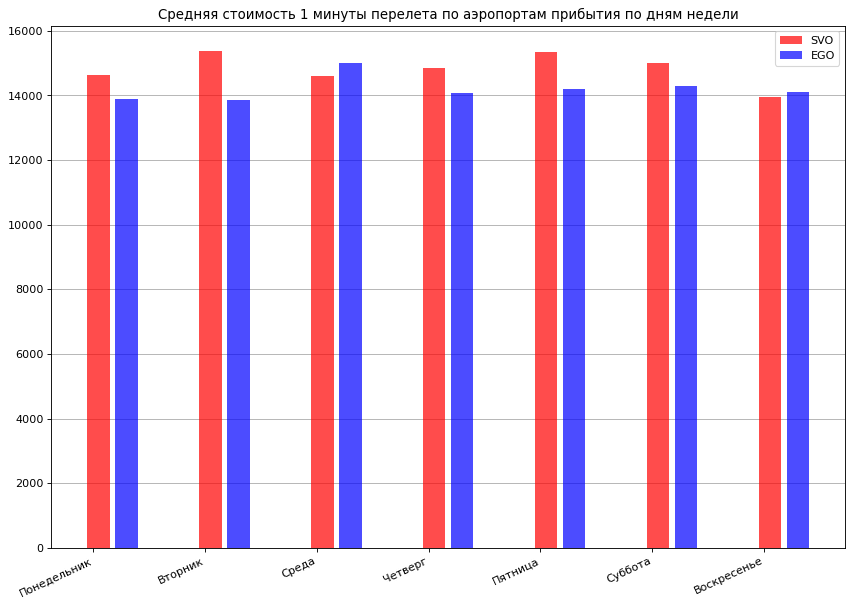

In [29]:
# построим гистрограмму распределения средней стоимости 1 минуты полета по дням недели по аэропортам прибытия
dpi = 80
fig = plt.figure(dpi = dpi, figsize = (1024 / dpi, 768 / dpi) )
mpl.rcParams.update({'font.size': 10})

data_names = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']
plt.title('Средняя стоимость 1 минуты перелета по аэропортам прибытия по дням недели')

ax = plt.axes()
ax.yaxis.grid(True, zorder = 1)

xs = weekdays

plt.bar([x + 0.05 for x in xs], [ d * 0.9 for d in amount_avg_SVO],
        width = 0.2, color = 'red', alpha = 0.7, label = 'SVO',
        zorder = 2)
plt.bar([x + 0.3 for x in xs], amount_avg_EGO,
        width = 0.2, color = 'blue', alpha = 0.7, label = 'EGO',
        zorder = 2)
plt.xticks(xs, data_names)

fig.autofmt_xdate(rotation = 25)

plt.legend(loc='upper right')

<ipython-input-30-09fd5b6a0aa7>:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


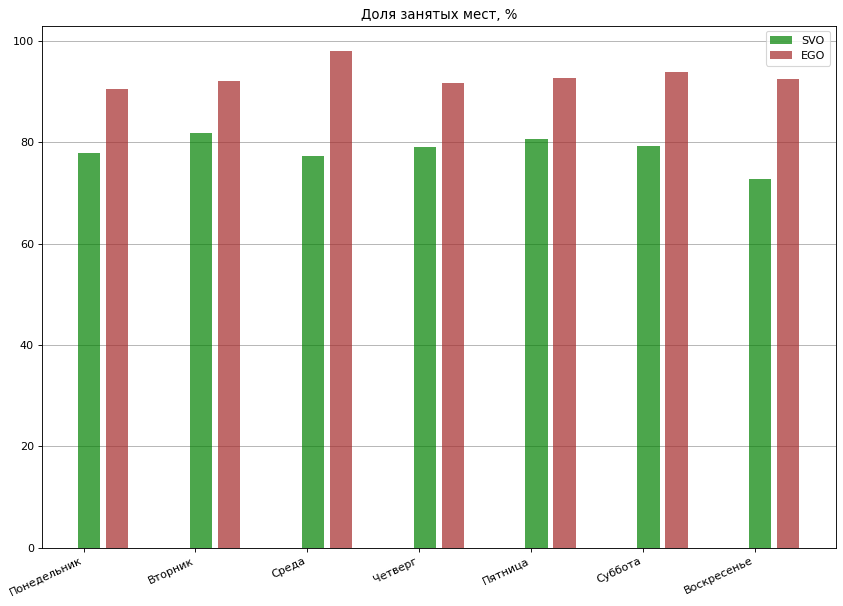

In [30]:
# построим гистограмму средней доли занятых мест по дням недели по аэропортам прибытия
perc_occupied_avg_SVO = []
perc_occupied_avg_EGO = []
for x in weekdays:
    perc_occupied_avg_SVO.append(df[(df.arrival_airport=='SVO') & (df.weekday == x)].perc_occupied.mean()*100)
    perc_occupied_avg_EGO.append(df[(df.arrival_airport=='EGO') & (df.weekday == x)].perc_occupied.mean()*100)
    
dpi = 80
fig = plt.figure(dpi = dpi, figsize = (1024 / dpi, 768 / dpi) )
mpl.rcParams.update({'font.size': 10})

data_names = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']
plt.title('Доля занятых мест, %')

ax = plt.axes()
ax.yaxis.grid(True, zorder = 1)

xs = weekdays

plt.bar([x + 0.05 for x in xs], [ d * 0.9 for d in perc_occupied_avg_SVO],
        width = 0.2, color = 'green', alpha = 0.7, label = 'SVO',
        zorder = 2)
plt.bar([x + 0.3 for x in xs], perc_occupied_avg_EGO,
        width = 0.2, color = 'brown', alpha = 0.7, label = 'EGO',
        zorder = 2)
plt.xticks(xs, data_names)

fig.autofmt_xdate(rotation = 25)

plt.legend(loc='upper right')

In [33]:
# рассмотрим статистику полученного датафрейма в разрезе аэропортов прибытия
df[df.arrival_airport=='SVO'].describe()

,flight_id,amount_total,actual_duration,amount_per_min,distance,fuel_costs,profit,seats,occupied_seats,perc_occupied,weekday
count,59.000000,5.900000e+01,59.000000,59.000000,59.0,59.000000,5.900000e+01,59.0,59.000000,59.000000,59.000000
mean,136298.661017,1.642576e+06,99.830508,16459.562494,971.0,161887.813559,1.480688e+06,130.0,113.118644,0.870143,3.966102
std,117.208716,1.318786e+05,0.985280,1383.367771,0.0,3918.845531,1.321374e+05,0.0,8.896115,0.068432,2.059177
min,136119.000000,1.398000e+06,98.000000,13938.613861,971.0,155048.000000,1.232260e+06,130.0,97.000000,0.746154,1.000000
25%,136193.500000,1.543200e+06,99.000000,15482.396040,971.0,158212.000000,1.382882e+06,130.0,107.000000,0.823077,2.000000
50%,136284.000000,1.628600e+06,100.000000,16366.336634,971.0,162425.000000,1.471970e+06,130.0,112.000000,0.861538,4.000000
75%,136407.000000,1.738400e+06,100.000000,17559.595960,971.0,165740.000000,1.578044e+06,130.0,120.000000,0.923077,6.000000
max,136486.000000,1.886000e+06,103.000000,18860.000000,971.0,170712.000000,1.720260e+06,130.0,130.000000,1.000000,7.000000


In [34]:
df[df.arrival_airport=='EGO'].describe()

,flight_id,amount_total,actual_duration,amount_per_min,distance,fuel_costs,profit,seats,occupied_seats,perc_occupied,weekday
count,59.000000,59.000000,59.000000,59.000000,59.0,59.000000,59.000000,59.0,59.000000,59.000000,59.000000
mean,136768.220339,710435.593220,50.084746,14183.994506,509.0,57532.084746,652903.508475,97.0,90.186441,0.929757,3.966102
std,112.072801,65835.266628,0.650945,1298.662502,0.0,1551.883908,65690.144086,0.0,8.101670,0.083522,2.059177
min,136571.000000,531000.000000,49.000000,10620.000000,509.0,54913.000000,473474.000000,97.0,64.000000,0.659794,1.000000
25%,136663.500000,667350.000000,50.000000,13215.588235,509.0,56033.000000,609396.500000,97.0,86.500000,0.891753,2.000000
50%,136769.000000,746400.000000,50.000000,14882.352941,509.0,57526.000000,690367.000000,97.0,95.000000,0.979381,4.000000
75%,136859.000000,765300.000000,50.500000,15180.000000,509.0,58700.000000,706013.000000,97.0,97.000000,1.000000,6.000000
max,136956.000000,765300.000000,51.000000,15618.367347,509.0,59874.000000,709267.000000,97.0,97.000000,1.000000,7.000000


Значительных отклонений в процессе исследования обнаружить не удалось, убыточных рейсов нет, но все-таки можно сделать несколько выводов:
1) По воскресеньям загрузка рейсов на SVO несколько снижается.
2) В расчете доходы-расходы наиболее "слабыми" себя показали только рейсы в EGO.
3) Наиболе провальными датами по прибыли были 30.01.2017, 23.02.2017, 28.02.2017.
4) Средняя наполняемость рейсов в SVO - около 80%.
5) Рейсы на более длинные расстояния более выгодны (доходность в среднем больше).
Рекомендации: 
1) По возможности, заменить самолет рейсом на SVO на менее вместительный, достаточна в среднем вместительность порядка 110 человек. 
Либо, как альтернатива п.1, рассмотреть более детально, почему загрузка низкая, возможно откорректировать ценовую политику, или поменять 
время вылета, тем самым увеличить количество пассажиров на рейсах текущей вместительности.
2) Открывать новые направления на более длинные расстояния.
3) Продумать маркетинговые акции по привлечению пассажиров в праздничные даты и в последние дни месяца.